In [16]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
import sklearn.metrics

import dataset
import data_reader
import plots

In [17]:
# Choosing device for tensor processing

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU :", device)
else:
    device = torch.device("cpu")
    print("Using CPU ")

Using GPU : cuda:0


In [18]:
EXP_NAME = "25ep"

DATA_SET_NAME = f"data_set_x20_100%_split"

In [19]:
def wsi_class(wsi_data_set):
    global net
    """
    Input: 
    - wsi_data_set, patches from a given WSI, dataset object
    - y, patch labels
    Outputs:
    - output, Prediction
    """
    wsi_dataloader = DataLoader(wsi_data_set, batch_size=64)
    outputs = []
    loss = 0

    for batch_X, batch_y in iter(wsi_dataloader):
        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device) 

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        normalize = transforms.Normalize(mean=mean, std=std)

        for i, x in enumerate(batch_X):
            batch_X[i] = normalize(batch_X[i]/255) # Np array
        
        output = net(batch_X)
        outputs.extend(output.cpu())
        #print(batch_y.size(), output.size())
        loss += nn.CrossEntropyLoss()(output, batch_y).cpu()

    y_pred = [torch.argmax(i) for i in outputs] # 1 means positive diagnosis: (1,0) => 1
    prob_neg = y_pred.count(0)/len(y_pred)
    prob_coad = y_pred.count(1)/len(y_pred)
    prob_read = y_pred.count(2)/len(y_pred)

    output = [prob_neg, prob_coad, prob_read]
    loss = loss/len(wsi_data_set)

    return output, loss

Split:  0
Read lmdb
8207


  0%|          | 0/52 [00:00<?, ?it/s]

Mean Loss:  0.0026696208
Acc:  0.9615384615384616
f1:  0.9473684210526316
CONF: 
 [[32  2]
 [ 0 18]] 

Split:  1
Read lmdb
9777


  0%|          | 0/51 [00:00<?, ?it/s]

Mean Loss:  5.5355344e-05
Acc:  1.0
f1:  1.0
CONF: 
 [[33  0]
 [ 0 18]] 

Split:  2
Read lmdb
9243


  0%|          | 0/52 [00:00<?, ?it/s]

Mean Loss:  0.0004706877
Acc:  1.0
f1:  1.0
CONF: 
 [[33  0]
 [ 0 19]] 

Split:  3
Read lmdb
8730


  0%|          | 0/52 [00:00<?, ?it/s]

Mean Loss:  0.0017498311
Acc:  0.9807692307692307
f1:  0.9743589743589743
CONF: 
 [[32  1]
 [ 0 19]] 

Split:  4
Read lmdb
8520


  0%|          | 0/53 [00:00<?, ?it/s]

Mean Loss:  0.002837992
Acc:  0.9811320754716981
f1:  0.9743589743589743
CONF: 
 [[33  1]
 [ 0 19]] 

Split:  5
Read lmdb
8464


  0%|          | 0/51 [00:00<?, ?it/s]

Mean Loss:  5.7074456e-05
Acc:  1.0
f1:  1.0
CONF: 
 [[33  0]
 [ 0 18]] 

Split:  6
Read lmdb
8236


  0%|          | 0/51 [00:00<?, ?it/s]

Mean Loss:  0.0022486066
Acc:  0.9803921568627451
f1:  0.972972972972973
CONF: 
 [[32  1]
 [ 0 18]] 

Split:  7
Read lmdb
7714


  0%|          | 0/51 [00:00<?, ?it/s]

Mean Loss:  0.000114034374
Acc:  1.0
f1:  1.0
CONF: 
 [[33  0]
 [ 0 18]] 

Split:  8
Read lmdb
9329


  0%|          | 0/51 [00:00<?, ?it/s]

Mean Loss:  0.00011101454
Acc:  1.0
f1:  1.0
CONF: 
 [[33  0]
 [ 0 18]] 

Split:  9
Read lmdb
8209


  0%|          | 0/52 [00:00<?, ?it/s]

Mean Loss:  0.004740973
Acc:  0.9807692307692307
f1:  0.972972972972973
CONF: 
 [[33  1]
 [ 0 18]] 

[[327.   6.]
 [  0. 183.]]


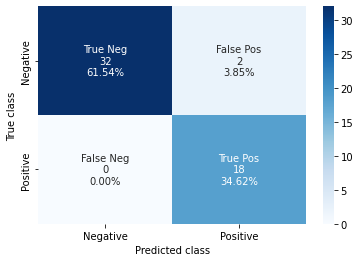

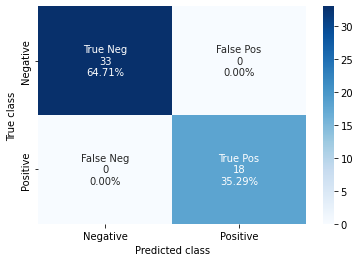

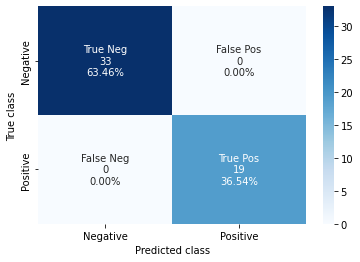

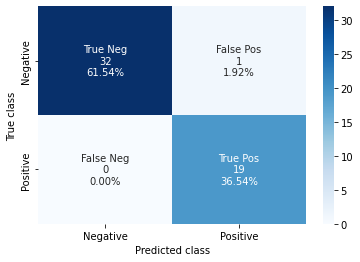

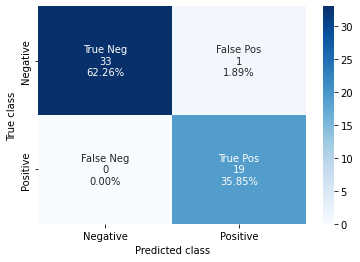

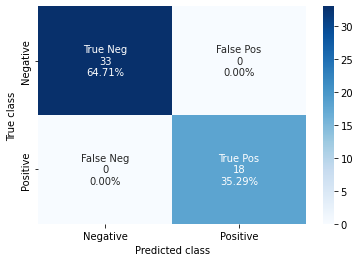

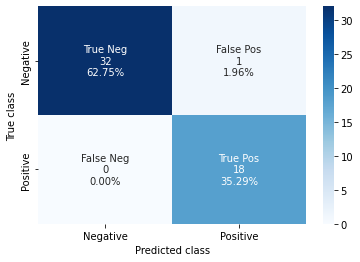

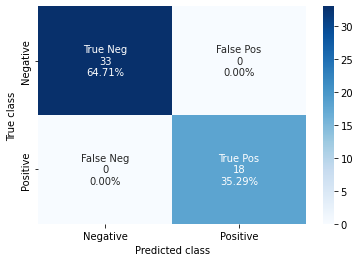

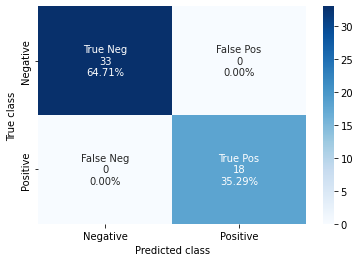

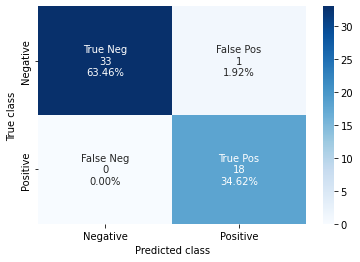

In [20]:
n_splits = 10

tot_conf = np.zeros((2,2))

for SPLIT in range(n_splits):
    print("Split: ", SPLIT)
    
    if SPLIT == n_splits-1: # For the final split for validation we take the firs one for test
        SPLIT_NAME = DATA_SET_NAME + f"{0}" # Test set 
    else:
        SPLIT_NAME = DATA_SET_NAME + f"{SPLIT+1}" # Test set
    
    MODEL_NAME = EXP_NAME + f"{SPLIT}"

    net = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading

    X, y, _ , case_ids = data_reader.read_lmdb(f"D:\data\WSI\patches\{SPLIT_NAME}")

    sample_ids = [case_id.split("_")[1] for case_id in case_ids] # Taking only the sample_id, not patch id

    outputs, loss, labels = [], [], []
    unique_sample_ids = np.unique(sample_ids)
    sample_ids = np.array(sample_ids)

    for unique_sample_id in tqdm(unique_sample_ids):

        net.eval()
        with torch.no_grad():
            ii = np.where(sample_ids == unique_sample_id)[0]

            wsi_data_set = dataset.PatchDataset([], [], [])

            wsi_data_set.inputs.extend(X[ii[0]:ii[-1]])# Taking the patches from a given wsi
            wsi_data_set.labels.extend(y[ii[0]:ii[-1]])
            wsi_data_set.case_ids.extend(sample_ids)
            
            output = wsi_class(wsi_data_set)
            outputs.append(output[0])
            loss.append(output[1])
            labels.append(np.argmax(y[ii[0]])) # OHE to binary

            del wsi_data_set

    loss = np.mean(loss)

    out = [np.argmax(output) for output in outputs]

    conf_m = sklearn.metrics.confusion_matrix(labels, out, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(labels, out)
    f1 = sklearn.metrics.f1_score(labels, out)
    auc = 0 #sklearn.metrics.roc_auc_score(y_true, y_pred, average= "micro", multi_class="ovr") #!!!!

    print("Mean Loss: ", loss)
    print("Acc: ", acc)
    print("f1: ", f1)
    print("CONF: \n", conf_m, "\n")

    tot_conf += conf_m

    plots.plot_conf(SPLIT_NAME, conf_m)

print(tot_conf)

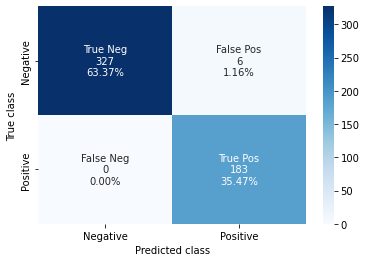

In [23]:
tot_conf = np.array([[327, 6],[0, 183]])

plots.plot_conf("10CV", tot_conf)

acc = 0.9888
f1 = 0.9914

In [12]:
roc = []

# ROC
for i in reversed(np.linspace(0,1,10000)):
    out = [1 if output>i else 0 for output in outputs]
    conf_m = confusion_matrix(labels, out, labels=[0, 1])
    roc.append(conf_m[1][1]/(conf_m[1][0]+conf_m[1][1]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
plots.plot_roc(SPLIT_NAME, roc)

In [ ]:
# Choosing only the images from the according splits (10CV)

SPLITS = 1 # Number of iterations > n_splits

for SPLIT in range(SPLITS):
    MODEL_NAME = EXP_NAME + f"{SPLIT}"
    SPLIT_NAME = DATA_SET_NAME + f"{SPLIT}"

    test_set = dataset.PatchDataset([], [], [])

    X_, y_, _ , case_ids_ = data_reader.read_lmdb(f"C:/Users/Alejandro/Desktop/heterogeneous-data/data/WSI/patches/{SPLIT_NAME}")

    test_set.inputs.extend(X_)
    test_set.labels.extend(y_)
    test_set.case_ids.extend(case_ids_)

    print(f"Loading model {MODEL_NAME}\n")

    net = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading

    test_wsi()

    del test_set
